[*********************100%***********************]  5 of 5 completed


First trading date: 2021-01-04
Price data shape: (1486, 5)
Returns (% ) shape: (1485, 5)
[backtest] window_len=252, T=1485, first_trade_date=2021-01-04 00:00:00
[backtest] window_len=252, T=1485, first_trade_date=2021-01-04 00:00:00
[backtest] window_len=252, T=1485, first_trade_date=2021-01-04 00:00:00

=== Buy & Hold: AAPL ===
Annualised return: 17.03%
Annualised vol   : 28.08%
Sharpe (rf=4.0%): 0.46

=== Buy & Hold: GOOG ===
Annualised return: 30.51%
Annualised vol   : 31.11%
Sharpe (rf=4.0%): 0.85

=== Buy & Hold: MSFT ===
Annualised return: 18.61%
Annualised vol   : 25.85%
Sharpe (rf=4.0%): 0.57

=== Buy & Hold: WMT ===
Annualised return: 20.16%
Annualised vol   : 20.95%
Sharpe (rf=4.0%): 0.77

=== Buy & Hold: XOM ===
Annualised return: 28.73%
Annualised vol   : 27.14%
Sharpe (rf=4.0%): 0.91

=== VAR: Binary weights, rolling window ===
Annualised return: 19.65%
Annualised vol   : 19.70%
Sharpe (rf=4.0%): 0.79

=== VAR: Forecast-weighted, rolling window ===
Annualised return: 19.64

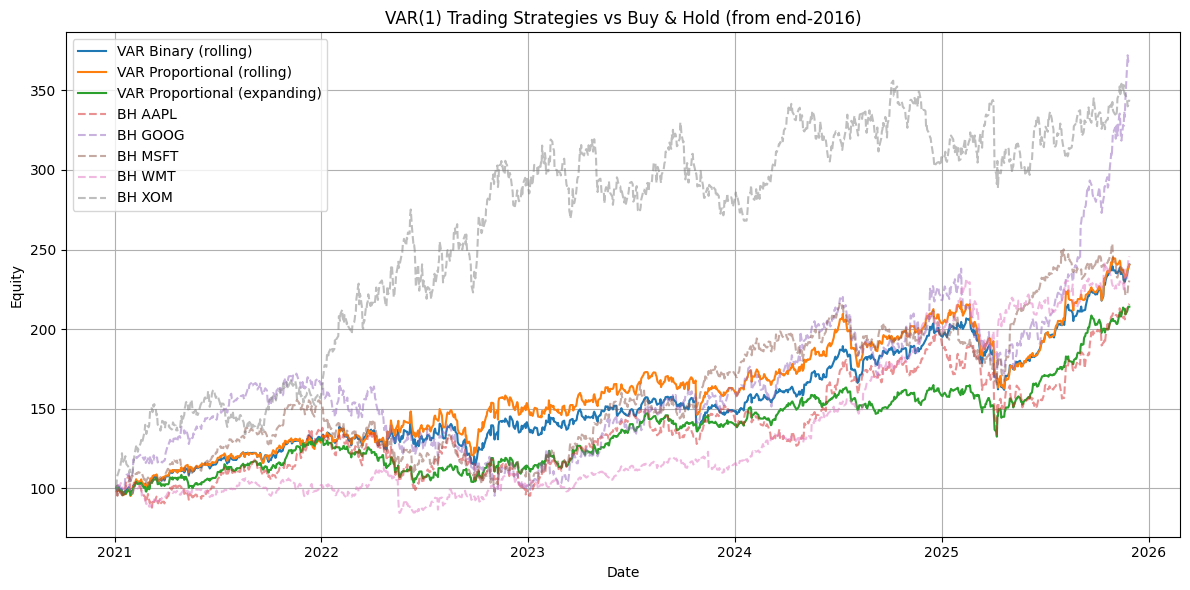

In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# =====================================================
# 1. Configuration
# =====================================================
TICKERS = ["AAPL", "GOOG", "MSFT", "WMT", "XOM"]  # closer to the video
START = "2020-01-01"
END = "2025-11-30"
TRADING_DAYS_PER_YEAR = 252
WINDOW_LEN = 252              # ~ 1 year of daily data for VAR(1)
INITIAL_CAPITAL = 100.0
RISK_FREE_RATE = 0.04         # 4% annual


# =====================================================
# 2. Data download & returns (PERCENT returns)
# =====================================================
def download_price_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end, auto_adjust=True)["Close"]
    if isinstance(data, pd.Series):
        data = data.to_frame()
    data = data[tickers]  # enforce column order
    return data.dropna()


def compute_percent_returns(prices: pd.DataFrame) -> pd.DataFrame:
    """
    Returns in % (like Excel: P_t / P_{t-1} * 100 - 100).
    This is what the VAR will be estimated on.
    """
    rets_dec = prices.pct_change()       # decimal
    rets_pct = rets_dec * 100.0          # % (e.g. 0.85% -> 0.85)
    return rets_pct.dropna()


prices = download_price_data(TICKERS, START, END)
returns_pct = compute_percent_returns(prices)

# First date we can start trading: after WINDOW_LEN days of returns
if len(returns_pct) <= WINDOW_LEN:
    raise ValueError("Not enough data for chosen WINDOW_LEN and START/END.")

TRADING_START = returns_pct.index[WINDOW_LEN]  # pandas.Timestamp
print("First trading date:", TRADING_START.date())

print("Price data shape:", prices.shape)
print("Returns (% ) shape:", returns_pct.shape)


# =====================================================
# 3. VAR(1) estimation on % returns
#     R_t = c + A R_{t-1} + e_t, where R in %
# =====================================================
def fit_var1(returns_window_pct: pd.DataFrame) -> np.ndarray:
    """
    Fit VAR(1) using OLS on a window of % returns.
    returns_window_pct: DataFrame (T_window, N), values in %
    Returns:
        B: (1+N, N) coefficient matrix such that
           R_t ≈ [1, R_{t-1}] @ B
    """
    R = returns_window_pct.values  # shape (T, N)
    R_lag = R[:-1, :]              # X (lagged)
    R_now = R[1:, :]               # Y (current)

    Tm1, N = R_lag.shape
    X = np.column_stack([np.ones(Tm1), R_lag])  # (T-1, 1+N)

    # B solves X B ≈ Y  -> multivariate OLS
    B, *_ = np.linalg.lstsq(X, R_now, rcond=None)  # (1+N, N)
    return B


def forecast_var1(B: np.ndarray, r_t_pct: np.ndarray) -> np.ndarray:
    """
    Given VAR(1) coefficients B and today's returns (in %, shape (N,)),
    compute next-day return forecast in %.
    """
    x = np.concatenate([[1.0], r_t_pct])  # shape (1+N,)
    r_hat_pct = x @ B                     # shape (N,)
    return r_hat_pct


# =====================================================
# 4. Weighting rules (from forecasts in %)
# =====================================================
def weights_binary_positive(forecasts_pct: np.ndarray) -> np.ndarray:
    """
    Equal-weight among stocks with positive forecast (in %), else zero.
    If all <= 0 -> all weights zero (stay in cash).
    """
    pos = forecasts_pct > 0.0
    count_pos = pos.sum()
    N = len(forecasts_pct)
    if count_pos == 0:
        return np.zeros(N)
    return pos.astype(float) / count_pos


def weights_forecast_proportional(forecasts_pct: np.ndarray) -> np.ndarray:
    """
    Weights proportional to positive forecast magnitudes (in %).
    Scaling by % vs decimal cancels out in this normalisation.
    If all <= 0 -> all weights zero (cash).
    """
    pos_forecasts = np.maximum(forecasts_pct, 0.0)
    total = pos_forecasts.sum()
    N = len(forecasts_pct)
    if total <= 0.0:
        return np.zeros(N)
    return pos_forecasts / total


# =====================================================
# 5. Backtest engine
# =====================================================
def backtest_var_strategy(
    returns_pct: pd.DataFrame,
    window_len: int = WINDOW_LEN,
    window_mode: str = "rolling",      # "rolling" or "expanding"
    weighting: str = "binary",         # "binary" or "proportional"
    initial_capital: float = INITIAL_CAPITAL,
) -> pd.DataFrame:
    dates = returns_pct.index
    N = returns_pct.shape[1]
    T = len(returns_pct)

    strategy_ret = pd.Series(0.0, index=dates, dtype=float)
    equity = pd.Series(initial_capital, index=dates, dtype=float)

    start_idx = window_len  # need at least window_len+1 obs for VAR(1)

    # Just to see what we *should* be doing:
    print(f"[backtest] window_len={window_len}, T={T}, "
          f"first_trade_date={dates[start_idx] if T > start_idx else 'N/A'}")

    for t in range(start_idx, T - 1):
        # Build estimation window
        if window_mode == "rolling":
            start_window = t - window_len
            window_df = returns_pct.iloc[start_window: t + 1]
        elif window_mode == "expanding":
            window_df = returns_pct.iloc[: t + 1]
            if len(window_df) < window_len + 1:
                # Carry forward equity, no trade
                equity.iloc[t + 1] = equity.iloc[t]
                continue
        else:
            raise ValueError("window_mode must be 'rolling' or 'expanding'")

        # Fit VAR(1)
        B = fit_var1(window_df)

        # Forecast next-day returns in %
        r_t_pct = returns_pct.iloc[t].values
        forecasts_pct = forecast_var1(B, r_t_pct)

        # Weights
        if weighting == "binary":
            w = weights_binary_positive(forecasts_pct)
        elif weighting == "proportional":
            w = weights_forecast_proportional(forecasts_pct)
        else:
            raise ValueError("weighting must be 'binary' or 'proportional'")

        # Realised portfolio return next day (in %, convert to decimal)
        r_next_pct = returns_pct.iloc[t + 1].values
        port_ret_pct = float(np.dot(w, r_next_pct))
        port_ret_dec = port_ret_pct / 100.0

        strategy_ret.iloc[t + 1] = port_ret_dec
        equity.iloc[t + 1] = equity.iloc[t] * (1.0 + port_ret_dec)

    return pd.DataFrame({"strategy_ret": strategy_ret, "equity": equity})



# =====================================================
# 6. Performance metrics (use decimals)
# =====================================================
def annualised_return(returns_dec: pd.Series,
                      freq: int = TRADING_DAYS_PER_YEAR) -> float:
    r = returns_dec.dropna()
    if len(r) == 0:
        return np.nan
    total = (1.0 + r).prod()
    years = len(r) / freq
    if years <= 0:
        return np.nan
    return total ** (1.0 / years) - 1.0


def annualised_vol(returns_dec: pd.Series,
                   freq: int = TRADING_DAYS_PER_YEAR) -> float:
    r = returns_dec.dropna()
    if len(r) == 0:
        return np.nan
    return r.std(ddof=1) * np.sqrt(freq)


def sharpe_ratio(returns_dec: pd.Series,
                 rf: float = RISK_FREE_RATE,
                 freq: int = TRADING_DAYS_PER_YEAR) -> float:
    ann_ret = annualised_return(returns_dec, freq)
    ann_vol = annualised_vol(returns_dec, freq)
    if ann_vol == 0 or np.isnan(ann_vol):
        return np.nan
    return (ann_ret - rf) / ann_vol


def summarise_performance(returns_dec: pd.Series, name: str):
    ann_ret = annualised_return(returns_dec)
    ann_vol = annualised_vol(returns_dec)
    sr = sharpe_ratio(returns_dec)
    print(f"\n=== {name} ===")
    print(f"Annualised return: {ann_ret*100:.2f}%")
    print(f"Annualised vol   : {ann_vol*100:.2f}%")
    print(f"Sharpe (rf={RISK_FREE_RATE*100:.1f}%): {sr:.2f}")


# =====================================================
# 7. Run VAR strategies
# =====================================================
res_binary_rolling = backtest_var_strategy(
    returns_pct,
    window_len=WINDOW_LEN,
    window_mode="rolling",
    weighting="binary",
    initial_capital=INITIAL_CAPITAL,
)

res_prop_rolling = backtest_var_strategy(
    returns_pct,
    window_len=WINDOW_LEN,
    window_mode="rolling",
    weighting="proportional",
    initial_capital=INITIAL_CAPITAL,
)

res_prop_expanding = backtest_var_strategy(
    returns_pct,
    window_len=WINDOW_LEN,
    window_mode="expanding",
    weighting="proportional",
    initial_capital=INITIAL_CAPITAL,
)

# Daily decimal returns for buy & hold of each stock
returns_dec = returns_pct / 100.0


# =====================================================
# 8. Performance summary (from TRADING_START onward)
# =====================================================
eval_slice = slice(TRADING_START, None)

for i, ticker in enumerate(TICKERS):
    summarise_performance(returns_dec[ticker].loc[eval_slice],
                          f"Buy & Hold: {ticker}")

summarise_performance(res_binary_rolling["strategy_ret"].loc[eval_slice],
                      "VAR: Binary weights, rolling window")

summarise_performance(res_prop_rolling["strategy_ret"].loc[eval_slice],
                      "VAR: Forecast-weighted, rolling window")

summarise_performance(res_prop_expanding["strategy_ret"].loc[eval_slice],
                      "VAR: Forecast-weighted, expanding window")


# =====================================================
# 9. Plot equity curves (normalised from TRADING_START)
# =====================================================
plt.figure(figsize=(12, 6))

# Normalise all curves to INITIAL_CAPITAL at TRADING_START for fair comparison
def normalise_equity(equity: pd.Series, start_date: str) -> pd.Series:
    eq = equity.copy()
    eq = eq.loc[eval_slice]
    base = eq.iloc[0]
    if base == 0 or np.isnan(base):
        return INITIAL_CAPITAL * eq / eq.iloc[0]
    return INITIAL_CAPITAL * eq / base


plt.plot(normalise_equity(res_binary_rolling["equity"], TRADING_START),
         label="VAR Binary (rolling)")
plt.plot(normalise_equity(res_prop_rolling["equity"], TRADING_START),
         label="VAR Proportional (rolling)")
plt.plot(normalise_equity(res_prop_expanding["equity"], TRADING_START),
         label="VAR Proportional (expanding)")

for ticker in TICKERS:
    bh_equity = INITIAL_CAPITAL * (1.0 + returns_dec[ticker].loc[eval_slice]).cumprod()
    plt.plot(bh_equity, linestyle="--", alpha=0.5, label=f"BH {ticker}")

plt.title("VAR(1) Trading Strategies vs Buy & Hold (from end-2016)")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Axes: xlabel='Date'>

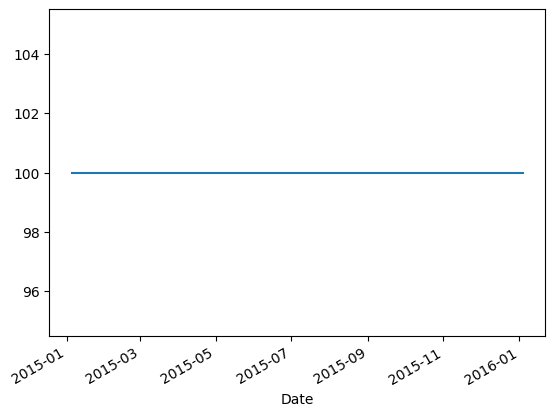

In [7]:
res_prop_rolling["equity"].plot()


In [8]:
print("Prices index range:", prices.index.min(), "→", prices.index.max())
print("Returns index range:", returns_pct.index.min(), "→", returns_pct.index.max())
print("res_prop_rolling index range:", res_prop_rolling.index.min(), "→", res_prop_rolling.index.max())
print(res_prop_rolling.tail())


Prices index range: 2015-01-02 00:00:00 → 2023-12-29 00:00:00
Returns index range: 2015-01-05 00:00:00 → 2023-12-29 00:00:00
res_prop_rolling index range: 2015-01-05 00:00:00 → 2023-12-29 00:00:00
            strategy_ret  equity
Date                            
2023-12-22      0.003678     NaN
2023-12-26     -0.000306     NaN
2023-12-27     -0.002779     NaN
2023-12-28      0.002140     NaN
2023-12-29     -0.003498     NaN


In [11]:
prices.dropna()

Ticker,AAPL,GOOG,MSFT,WMT,XOM
Date,,,,,
2015-01-02,24.237547,25.990791,39.858444,23.266569,57.916908
2015-01-05,23.554735,25.448997,39.491917,23.198854,56.332188
2015-01-06,23.556963,24.859165,38.912292,23.377621,56.032730
2015-01-07,23.887278,24.816574,39.406677,23.997881,56.600475
2015-01-08,24.805079,24.894821,40.565960,24.504375,57.542576
...,...,...,...,...,...
2023-12-22,191.788757,141.749985,369.077118,51.213169,95.059578
2023-12-26,191.243912,141.849289,369.155945,51.134701,95.274101
2023-12-27,191.342957,140.478683,368.574615,51.615288,94.826370
